In [1]:
from pandas.core.interchange.dataframe_protocol import DataFrame
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import DataFrame, Series
import numpy as np
from sklearn.cluster import DBSCAN
from umap import UMAP
from sklearn.manifold import trustworthiness
import optuna


C:\Users\achim\Desktop\OSMI_Mental_Health\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_pickle(r"/data/edited/full_df_rdy_1.pkl")

In [3]:
X = df.to_numpy()

def objective(trial):
    params = {
        "n_components": trial.suggest_int("n_components", 2, 20),
        "n_neighbors": trial.suggest_int("n_neighbors", 2, 20),
        "metric": trial.suggest_categorical("metric", ["euclidean", "cosine", "hamming", "jaccard"]),
        "min_dist": trial.suggest_float("min_dist", 0.1, 1.0),

    }
    n_clusters = trial.suggest_int("n_clusters", 2, 10)

    umap = UMAP(random_state=42, **params)

    reduced_X = umap.fit_transform(X)
    labels = KMeans(n_clusters=n_clusters, random_state=42).fit_predict(reduced_X)

    score = silhouette_score(reduced_X, labels, metric=params["metric"])

    return score

In [99]:
study = optuna.create_study(
        direction="maximize"
    )

study.optimize(objective, n_trials=150)
best_params = study.best_params



[I 2025-07-08 19:22:19,557] A new study created in memory with name: no-name-5742ef39-adb3-4506-b09c-00da2e759fd0
C:\Users\achim\Desktop\OSMI_Mental_Health\venv\Lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
C:\Users\achim\Desktop\OSMI_Mental_Health\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\achim\Desktop\OSMI_Mental_Health\venv\Lib\site-packages\sklearn\metrics\pairwise.py:2463: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
[I 2025-07-08 19:22:22,088] Trial 0 finished with value: 0.0 and parameters: {'n_components': 14, 'n_neighbors': 16, 'metric': 'jaccard', 'min_dist': 0.9443491721854826, 'n_clusters': 2}. Best is trial 0 with value: 0.0.
C:\Users\achim\Desktop\OSMI_Mental_Health\ven

TypeError: UMAP.__init__() got an unexpected keyword argument 'n_clusters'

In [100]:
best_params

{'n_components': 9,
 'n_neighbors': 10,
 'metric': 'cosine',
 'min_dist': 0.10343826058705334,
 'n_clusters': 2}

In [105]:
n_components = best_params["n_components"]
n_neighbors = best_params["n_neighbors"]
metric = best_params["metric"]
min_dist = best_params["min_dist"]
n_clusters = best_params["n_clusters"]

In [8]:
# n_cluster wird auf 4 gesetzt zur besseren Weiterverarbeitung (genauere Unterscheidung für Cluster-Analyse)
umap = UMAP(n_components=9, n_neighbors=10, metric="cosine", min_dist=0.10343826, random_state=42)
kmeans = KMeans(n_clusters=4, random_state=42)

In [9]:
X_reduced = umap.fit_transform(X)
labels = kmeans.fit_predict(X_reduced)

C:\Users\achim\Desktop\OSMI_Mental_Health\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [10]:
pd.Series(labels).to_pickle("../data/edited/labels.pkl")

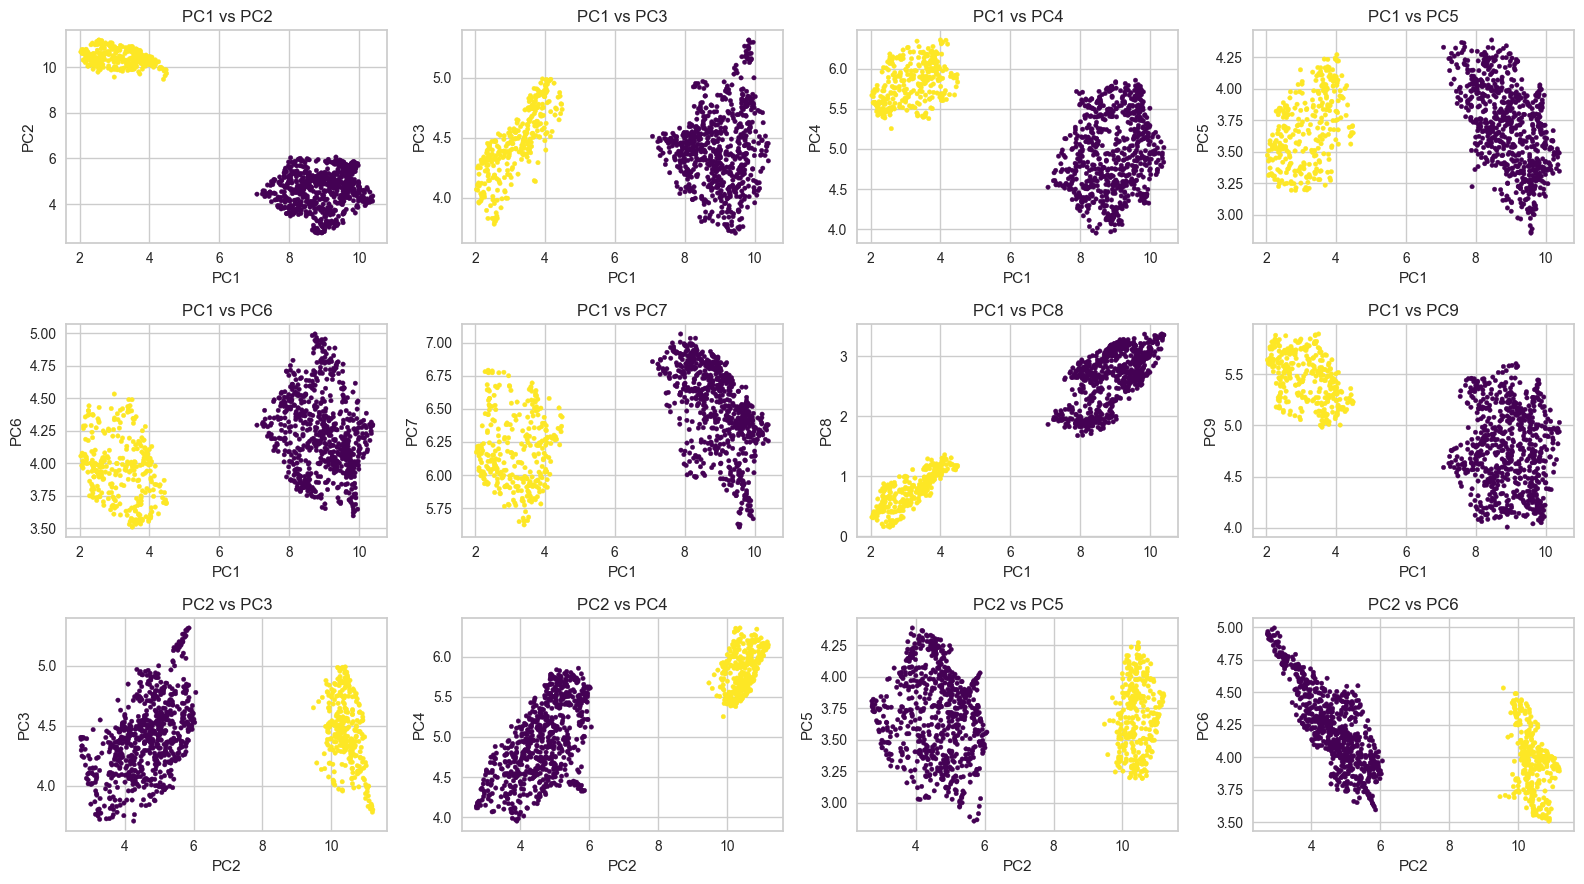

In [130]:
# Plot für 2 Cluster bei KMeans (n_clusters=2)
from matplotlib.gridspec import GridSpec
from itertools import combinations


pairs = list(combinations(range(9), 2))[:12] # Alle 2er-Paare aus 9 Komponenten
n_plots = len(pairs)
cols = 4
rows = (n_plots // cols) + int(n_plots % cols > 0)

fig = plt.figure(figsize=(4 * cols, 3 * rows))
gs = plt.GridSpec(rows, cols)

for i, (x_idx, y_idx) in enumerate(pairs):
    row = i // cols
    col = i % cols
    ax = fig.add_subplot(gs[row, col])
    ax.scatter(X_reduced[:, x_idx], X_reduced[:, y_idx], c=labels, cmap='viridis', s=10)
    ax.set_title(f"PC{x_idx+1} vs PC{y_idx+1}")
    ax.set_xlabel(f"PC{x_idx+1}")
    ax.set_ylabel(f"PC{y_idx+1}")

plt.tight_layout()
plt.savefig("Plots/zwölf Komponenten kombiniert.png", dpi=300)
plt.show()


In [93]:
def objective(trial):
    # 1. PCA-Anzahl optimieren
    n_comp = trial.suggest_int("n_components", 2, min(X.shape[1], 50))  # z. B. max 50
    X_pca = PCA(n_components=n_comp).fit_transform(X)

    # 2. DBSCAN-Parameter optimieren
    eps = trial.suggest_float("eps", 0.1, 5.0)
    min_samples = trial.suggest_int("min_samples", 3, 20)

    # 3. DBSCAN-Modell trainieren
    try:
        labels = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit_predict(X_pca)

        # Noise-Handling: Wenn alle Punkte -1 → ungültige Lösung
        if len(set(labels)) <= 1 or (set(labels) == {-1}):
            return -1.0

        score = silhouette_score(X_pca, labels)
        return score
    except Exception as e:
        return -1.0

# Optuna-Optimierung starten
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

best_params_dbscan = study.best_params

[I 2025-07-08 19:11:47,506] A new study created in memory with name: no-name-553c16c4-ef84-4037-86fe-c7113e2293bf
[I 2025-07-08 19:11:47,540] Trial 0 finished with value: -1.0 and parameters: {'n_components': 8, 'eps': 3.8354848787103157, 'min_samples': 9}. Best is trial 0 with value: -1.0.
[I 2025-07-08 19:11:47,599] Trial 1 finished with value: 0.125463196687936 and parameters: {'n_components': 14, 'eps': 4.39593480127863, 'min_samples': 16}. Best is trial 1 with value: 0.125463196687936.
[I 2025-07-08 19:11:47,610] Trial 2 finished with value: -1.0 and parameters: {'n_components': 43, 'eps': 0.5492309308683039, 'min_samples': 7}. Best is trial 1 with value: 0.125463196687936.
[I 2025-07-08 19:11:47,620] Trial 3 finished with value: -1.0 and parameters: {'n_components': 47, 'eps': 1.2921771910212232, 'min_samples': 7}. Best is trial 1 with value: 0.125463196687936.
[I 2025-07-08 19:11:47,646] Trial 4 finished with value: -1.0 and parameters: {'n_components': 7, 'eps': 3.1854001065911